# flats-in-cracow machine learning

## Imports

In [1]:
from datetime import datetime
from distutils.dir_util import copy_tree
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib.ticker import MaxNLocator
from pylab import rcParams
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import (GradientBoostingRegressor, RandomForestRegressor,
                              VotingRegressor)
from sklearn.impute import KNNImputer
from sklearn.metrics import (mean_absolute_error, mean_squared_error,
                             mean_squared_log_error)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

## Setup

In [2]:
# Create directory for images 
Path("img").mkdir(parents=True, exist_ok=True)

# Set default figure size
rcParams['figure.figsize'] = (4, 4)

# Tell pandas how to display floats
pd.options.display.float_format = "{:,.2f}".format

## Data loading

In [3]:
path = '../flats-data/cleaned_data.csv'

In [4]:
data = pd.read_csv(path, lineterminator='\n')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3332 entries, 0 to 3331
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   District   3332 non-null   object
 1   Amount     3332 non-null   int64 
 2   Seller     3332 non-null   object
 3   Area       3332 non-null   int64 
 4   Rooms      3332 non-null   int64 
 5   Bathrooms  3332 non-null   int64 
 6   Parking    3332 non-null   object
 7   Garden     3332 non-null   bool  
 8   Balcony    3332 non-null   bool  
 9   Terrace    3332 non-null   bool  
 10  Floor      3332 non-null   bool  
 11  New        3332 non-null   bool  
 12  Estate     3332 non-null   bool  
 13  Townhouse  3332 non-null   bool  
 14  Apartment  3332 non-null   bool  
 15  Land       3332 non-null   bool  
 16  Studio     3332 non-null   bool  
dtypes: bool(10), int64(4), object(3)
memory usage: 214.9+ KB


In [6]:
data.head()

,District,Amount,Seller,Area,Rooms,Bathrooms,Parking,Garden,Balcony,Terrace,Floor,New,Estate,Townhouse,Apartment,Land,Studio
0,pradnik czerwony,403072,realtor,43,2,1,covered,False,False,True,True,True,False,False,False,True,False
1,pradnik bialy,600000,realtor,57,3,1,street,False,False,False,False,False,False,False,False,False,False
2,biezanow,371966,realtor,52,3,1,garage,False,True,False,False,True,False,False,False,False,False
3,nowa huta,349000,realtor,47,2,1,no parking,False,False,False,False,True,False,False,False,False,False
4,pradnik bialy,370635,realtor,34,2,1,garage,False,True,False,True,True,False,False,False,True,False


## Feature engineering

The next step is to engineer features. We add columns describing the `Total Rooms` in the property, ratio of `Area to Rooms` and so on.

In [7]:
data['Log Area'] = np.round(np.log(data['Area']), 2)
data['Bool Sum'] = data.select_dtypes(bool).sum(axis=1)
# Avoid division by zero
data['Area to Bool Sum'] = round(data['Area'] / (data.select_dtypes(bool).sum(axis=1) + 1), 2)
data['Rooms to Bool Sum'] = round(data['Rooms'] / (data.select_dtypes(bool).sum(axis=1) + 1), 2)
data['Rooms to Bathrooms' ] = round(data['Rooms'] / data['Bathrooms'], 2)
data['Total Rooms'] = round(data['Rooms'] + data['Bathrooms'], 2)
data['Area to Rooms'] = round(data['Area'] / data['Rooms'], 2)
data['Area to Bathrooms'] = round(data['Area'] / data['Rooms'], 2)
data['Area to Total Rooms'] = round(data['Area'] / data['Total Rooms'], 2)

## Data split

We decide to use 80% of the data to train the model and 20% to check performance.
We make sure to remove the `Amount` column from the training data since this is our target.

In [8]:
X = data.drop(['Amount'], axis=1)
y = data['Amount']

split = train_test_split(X, y, train_size=.8,
                               random_state=123)

X_train, X_test, y_train, y_test = split

## Models

Next step is to create the models and associated piplines. We apply one hot encoding to categorical features and use the `ColumnTransformer` parameter `passthrough` to allow the rest of the columns to remain unchanged.

In [9]:
categorical = list(X.select_dtypes('object').columns)    
continuous = list(X.select_dtypes('int64'))
continuous += list(X.select_dtypes('float64'))

### Baseline model

For comparison purposes we create a model to give base predictions.

In [10]:
dmr = DummyRegressor()

dmr_ohe = Pipeline(
    steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]
)

dmr = Pipeline(steps = [('preprocessor', dmr_ohe),
                        ('regressor', dmr)])

# dmr.fit(X_train, y_train)

### Mulitlayer perceptron

For the neural network we apply the `MinMaxScaler` so that the continuous columns have values in $[0, 1]$ and then we apply `OneHotEncoder` to the categorical columns.

In [11]:
mlp = MLPRegressor(hidden_layer_sizes=(5, 10, 5), 
                   max_iter=10**4, 
                   random_state=123)

mlp_ohe = Pipeline(
    steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]
)

mlp_scale = Pipeline(
    steps=[('scale', MinMaxScaler())]
)

mlp_pre = ColumnTransformer(
    transformers = [
        ('scale', mlp_scale, continuous),        
        ('cat', mlp_ohe, categorical),
    ],
    remainder='passthrough'
)

mlp = Pipeline(steps = [('preprocessor', mlp_pre),
                        ('regressor', mlp)])

# mlp.fit(X_train, y_train)

### Gradient Boosting Regressor

For the gradient booster we only apply `OneHotEncoder` to the categorical columns.

In [12]:
gbr = GradientBoostingRegressor(random_state=123)

gbr_ohe = Pipeline(
    steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]
)

gbr_pre = ColumnTransformer(
    transformers = [
        ('cat', gbr_ohe, categorical)
    ],
    remainder='passthrough'
)

gbr = Pipeline(steps = [('preprocessor', gbr_pre),
                        ('regressor', gbr)])

# gbr.fit(X_train, y_train)

## Parameter tuning

We set up the training process to conduct basic parameter tuning and cross validation.

In [13]:
gbr_grid = {"regressor__max_depth": [5],#, 10, 15], 
            "regressor__n_estimators": [250],#, 500, 1000],
            "regressor__min_samples_split": [2, 4],
            "regressor__min_samples_leaf": [2, 4],
            "regressor__max_features": ['auto']}

gbr_gs = GridSearchCV(estimator=gbr, 
                      param_grid=gbr_grid,
                      cv=2,
                      n_jobs=8,
                      verbose=2)

In [14]:
mlp_grid = {'regressor__activation': ['relu'],
            'regressor__solver': ['adam'],
            'regressor__hidden_layer_sizes': [(100, 100), (100, 100, 100), (100, 200, 100)]}

mlp_gs = GridSearchCV(estimator=mlp, 
                      param_grid=mlp_grid,
                      cv=2,
                      n_jobs=8,
                      verbose=2)

## Training

In [15]:
dmr.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('onehot',
                                  OneHotEncoder(handle_unknown='ignore'))])),
                ('regressor', DummyRegressor())])

In [16]:
mlp = mlp_gs.fit(X_train, y_train).best_estimator_
mlp

Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   6 | elapsed:   34.0s remaining:   34.0s
[Parallel(n_jobs=8)]: Done   6 out of   6 | elapsed:  1.4min finished


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scale',
                                                  Pipeline(steps=[('scale',
                                                                   MinMaxScaler())]),
                                                  ['Area', 'Rooms', 'Bathrooms',
                                                   'Bool Sum', 'Total Rooms',
                                                   'Log Area',
                                                   'Area to Bool Sum',
                                                   'Rooms to Bool Sum',
                                                   'Rooms to Bathrooms',
                                                   'Area to Rooms',
                                                   'Area to Bathrooms',
                                                   'Area to Total Rooms']),
                                

In [17]:
gbr = gbr_gs.fit(X_train, y_train).best_estimator_
gbr

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    3.4s remaining:    5.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    3.8s finished


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['District', 'Seller',
                                                   'Parking'])])),
                ('regressor',
                 GradientBoostingRegressor(max_depth=5, max_features='auto',
                                           min_samples_leaf=2, n_estimators=250,
                                           random_state=123))])

### Voting Regressor

We create a `VotingRegressor` with uniform weights to be able to combine predictions of our models.

In [18]:
vote = VotingRegressor([['mlp', mlp], ['gbr', gbr]])
vote = vote.fit(X_train, y_train)

## Model performance

We obtain predictions for the testing set and compare `RMSE`, `MAE` and `MSLE` scores of our models.

In [19]:
y_pred_dum = dmr.predict(X_test)
y_pred_mlp = mlp.predict(X_test)
y_pred_gbr = gbr.predict(X_test)
y_pred_vote = vote.predict(X_test)

In [20]:
def get_scores(regressor, X_test, y_true, verb=True):
    """
    Obtain RMSE, MAE and MSLE for test set.
    """
    
    y_pred = regressor.predict(X_test)
    
    rmse = mean_squared_error(y_pred=y_pred, 
                              y_true=y_test, 
                              squared=False)
    
    mae = mean_absolute_error(y_pred=y_pred, 
                              y_true=y_test)
    
    msle = mean_squared_log_error(y_pred=y_pred, 
                                  y_true=y_test)    
    
    if verb:
        
        print(f'RMSE: {rmse:10.2f}')
        print(f'MAE:  {mae:10.2f}')
        print(f'MSLE: {msle:10.2f}')        
    
    return (rmse, mae, msle)

### Dummy

In [21]:
dmr_score = get_scores(regressor=dmr, 
                       X_test=X_test, 
                       y_true=y_test)

RMSE:  236321.44
MAE:   166523.32
MSLE:       0.14


### Multilayer Perceptrion

In [22]:
mlp_score = get_scores(regressor=mlp, 
                       X_test=X_test, 
                       y_true=y_test)

RMSE:  136022.60
MAE:    90414.08
MSLE:       0.04


### Gradient Boosting Regressor

In [23]:
gbr_score = get_scores(regressor=gbr, 
                       X_test=X_test, 
                       y_true=y_test)

RMSE:  129935.72
MAE:    80257.60
MSLE:       0.03


### Voting Regressor

In [24]:
vote_score = get_scores(regressor=vote, 
                        X_test=X_test, 
                        y_true=y_test)

RMSE:  127637.39
MAE:    82325.35
MSLE:       0.03


### Comparison

In [25]:
scores = [dmr_score,
          mlp_score,
          gbr_score,
          vote_score]

scores = pd.DataFrame(scores, 
                      index=['DMR', 'MLP', 'GBR', 'VOTE'], 
                      columns=['RMSE', 'MAE', 'MSLE'])

scores

,RMSE,MAE,MSLE
DMR,"236,321.44","166,523.32",0.14
MLP,"136,022.60","90,414.08",0.04
GBR,"129,935.72","80,257.60",0.03
VOTE,"127,637.39","82,325.35",0.03


## Visualizations 

We produce a couple of plots the visually inspect the performance of our model.
We use the test data set with the predicted `Amount` to produce the plots.

In [37]:
cols = ['Amount', 'Predicted Amount', 
        'District', 'Area', 'Total Rooms']

X_pred = X_test.copy()
X_pred.loc[:, 'Amount'] = y
X_pred.loc[:, 'Predicted Amount'] = vote.predict(X_test)
X_pred = X_pred.loc[:, cols]

X_pred.head()

,Amount,Predicted Amount,District,Area,Total Rooms
465,1190000,"1,048,316.55",stare miasto,93,7
2416,462707,"574,800.05",bronowice,65,5
1785,527000,"457,409.95",debniki,44,3
1316,890000,"831,409.10",podgorze,70,4
446,420000,"469,701.37",biezanow,59,4


On our first visual it can be seen that there exists a fairly linear relationship between the `Predicted Amount` and the `Area` of the property.

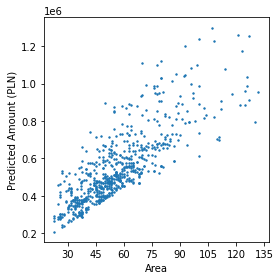

In [38]:
plt.scatter(X_pred['Area'], X_pred['Predicted Amount'], s=2)
plt.xlabel('Area')
plt.ylabel('Predicted Amount (PLN)')

ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.savefig('img/area_vs_amount.png')
plt.show()

On the second visual it can bee seen, as expected the more `Total Rooms` in a `Property` the more it should cost.

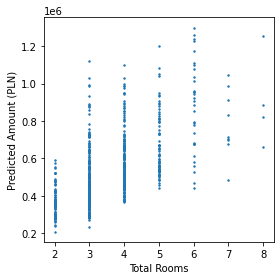

In [39]:
plt.scatter(X_pred['Total Rooms'], X_pred['Predicted Amount'], s=2)
plt.xlabel('Total Rooms')
plt.ylabel('Predicted Amount (PLN)')

ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

Next we want to check if the model distinguishes between districts. We group the data by `District` and calculate the mean of the predictions with the group. We produce a bar chart sorted from highest average to lowest. Clearly the model distinguishes between district that are near the city center (`stare miasto`, `zwierzyniec`) and those further away (`łagiewniki`, `bieżanów`).

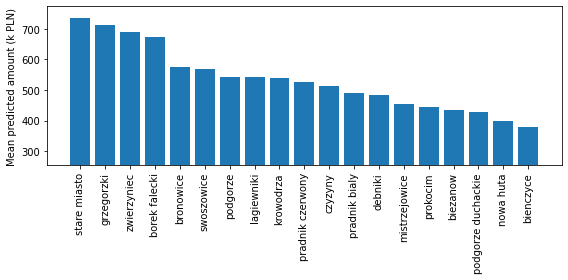

In [40]:
width = 1600
height = width/2
dpi = 200

X_grp = X_pred[['District', 'Predicted Amount']]
X_grp = X_grp.groupby('District', as_index=False).mean()
X_grp = X_grp.sort_values('Predicted Amount', ascending=False)

plt.figure(figsize=(width/dpi, height/dpi))

plt.bar(X_grp['District'], X_grp['Predicted Amount'] / 1000)

plt.ylabel('Mean predicted amount (k PLN)')
plt.ylim(X_grp['Predicted Amount'].min() * 0.67 / 1000, None)
plt.xticks(rotation=90)

plt.tight_layout()
plt.savefig('img/district_vs_avg_amount.png')
plt.show()

## Getting predictions

Next we would like see how the model handles sets of arbitrary parameters. We write a function to transform inputs to desired format and obtain prediction from the model.

In [41]:
def get_pred(district,
             seller,
             area,
             rooms,
             bathrooms,
             parking,
             garden,
             balcony,
             terrace,
             floor,
             new,
             estate,
             townhouse,
             apartment,
             land,
             studio):

    columns = ['District',
               'Seller',
               'Area',
               'Rooms',
               'Bathrooms',
               'Parking',
               'Garden',
               'Balcony',
               'Terrace',
               'Floor',
               'New',
               'Estate',
               'Townhouse',
               'Apartment',
               'Land',
               'Studio',
               'Log Area',
               'Bool Sum',
               'Area to Bool Sum',
               'Rooms to Bool Sum',
               'Rooms to Bathrooms',
               'Total Rooms',
               'Area to Rooms',
               'Area to Bathrooms',
               'Area to Total Rooms']
        
    log_area = np.log(area)

    all_bools = [garden,
                 balcony,
                 terrace,
                 floor,
                 new,
                 estate,
                 townhouse,
                 apartment,
                 land,
                 studio]
    
    bool_sum = sum(all_bools)
    area_to_bool_sum = area / (bool_sum + 1)
    rooms_to_bool_sum = rooms / (bool_sum + 1)    
    rooms_to_bathrooms = rooms / bathrooms        
    total_rooms = rooms + bathrooms
    area_to_rooms = area / total_rooms
    area_to_bathrooms = area / bathrooms
    area_to_total_rooms = area / total_rooms
    
    x = [district,
         seller,
         area,
         rooms,
         bathrooms,
         parking,
         garden,
         balcony,
         terrace,
         floor,
         new,
         estate,
         townhouse,
         apartment,
         land,
         studio,
         log_area,
         bool_sum,
         area_to_bool_sum,
         rooms_to_bool_sum,
         rooms_to_bathrooms,
         total_rooms,
         area_to_rooms,
         area_to_bathrooms,
         area_to_total_rooms]    
    
    x = pd.DataFrame([x], columns=columns)    
    x = float(vote.predict(x))

    return int(round(x, -3))    

We create lists of inputs for the model to predict.

In [42]:
areas = range(30, 120, 5)
rooms = range(1, 5)
districts = ['stare miasto', 
             'bronowice', 
             'podgórze', 
             'krowodrza']

Next we loop over lists of possible areas and rooms and plot the outputs. First we check how the model reacts to different districts.

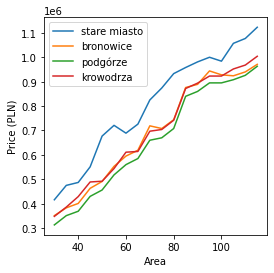

In [43]:
plt.figure()

for d in districts:
    value = list()
    for a in areas:
        pred = get_pred(district=d,
         seller='realtor',
         area=a,
         rooms=2,
         bathrooms=1,
         parking='street',
         garden=False,
         balcony=False,
         terrace=False,
         floor=False,
         new=True,
         estate=False,
         townhouse=True,
         apartment=False,
         land=False,
         studio=True)
        value.append(pred)
    plt.plot(areas, value, label=d)
    
plt.ylabel('Price (PLN)')
plt.xlabel('Area')
plt.legend(loc='best')
plt.savefig('img/area_vs_amount_by_district')
plt.show()

We do the same for different amounts of rooms.

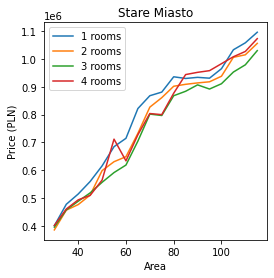

In [44]:
plt.figure()

for r in rooms:
    value = list()
    for a in areas:
        pred = get_pred(district='stare miasto',
         seller='owner',
         area=a,
         rooms=r,
         bathrooms=1,
         parking='street',
         garden=False,
         balcony=True,
         terrace=False,
         floor=False,
         new=True,
         estate=False,
         townhouse=True,
         apartment=False,
         land=False,
         studio=True)
        value.append(pred)
    plt.plot(areas, value, label=f'{r} rooms')
    
plt.title('Stare Miasto')
plt.ylabel('Price (PLN)')
plt.xlabel('Area')    
plt.legend(loc='best')
plt.savefig('img/area_vs_amount_by_rooms')
plt.show()

## Final training

The last step is to fit the model to the entire dataset and save it for later use.

In [59]:
start = datetime.now()

gbr.fit(X, y)
joblib.dump(gbr, f'../flats-model/gbr.joblib')

mlp.fit(X, y)
joblib.dump(mlp, f'../flats-model/mlp.joblib')

vote.fit(X, y)
joblib.dump(vote, f'../flats-model/vote.joblib')

end = datetime.now()

duration = (end - start).seconds / 60
print(f'Full training took {int(duration)} minutes.')

Full training took 157.06666666666666 minutes.


In [60]:
# Copy files to portfolio
# fromDirectory = '.'
# toDirectory = '/home/dev/Github/data-science-portfolio/flats-in-cracow'
# copy_tree(fromDirectory, toDirectory)